# The Transient Universe

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import scipy.stats
from scipy.optimize import curve_fit
from scipy import optimize
import corner
from IPython.display import display, Math
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import statsmodels.api as sm

C:\Users\loren\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\loren\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
data = np.load('transient.npy')
time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]

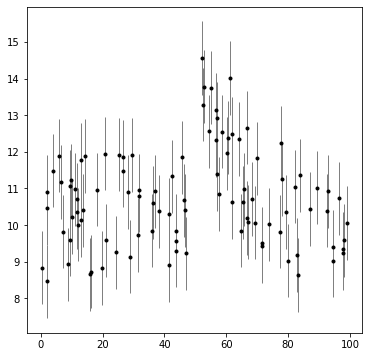

In [3]:
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, flux_err, 
            fmt='.k', lw=1, ecolor='gray');

In [4]:
# coding the model
def model(t, theta):
    A, b, t_0, alpha = theta
    
    arg = -alpha * (t - t_0)

    exp_term = np.exp(np.clip(arg, a_min=-700, a_max=700))
    
    return np.where(t < t_0, b, b + A * exp_term)
    
def model_fit(t, A, b, t_0, alpha):
    
    return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))

C:\Users\loren\AppData\Local\Temp\ipykernel_27548\3177836826.py:13: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))


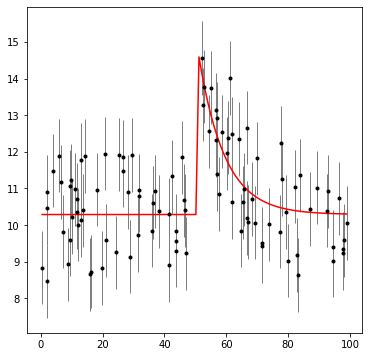

In [5]:
popt, pcov = curve_fit(model_fit, time, flux, p0=[5,10,50,0.1])
A_opt, b_opt, t0_opt, alpha_opt = popt
x_model = np.linspace(min(time), max(time), 100)
y_model = model_fit(x_model, A_opt, b_opt, t0_opt, alpha_opt)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, flux_err, 
            fmt='.k', lw=1, ecolor='gray');

plt.plot(x_model, y_model, color='r')
plt.show()

In [6]:
A = popt[0]
b = popt[1]
t_0 = popt[2]
alpha = popt[3]

In [24]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)

Here i define the loglikelihood and the prior.

In [8]:
def loglike(theta):
    
    A, b, t_0, alpha = theta
    model_flux = model(time, theta)
    
    return -0.5 * np.sum(((flux - model_flux) / flux_err) ** 2)

def ptform(u):
    
    x = np.array(u)
    
    '''lower_bound = [0, 0, 0, np.exp(-5)]
    upper_bound = [50, 50, 100, np.exp(5)]
    
    x = [lower_bound[i] + u[i] * (upper_bound[i] - lower_bound[i]) for i in range(len(u))]'''
    
    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    
    return x

In [9]:
ndim = 4
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=300, sample='rwalk')
sampler.run_nested()
sresults = sampler.results

4969it [04:44, 17.46it/s, +300 | bound: 86 | nc: 1 | ncall: 104049 | eff(%):  5.079 | loglstar:   -inf < -48.760 <    inf | logz: -64.042 +/-  0.219 | dlogz:  0.001 >  0.309]


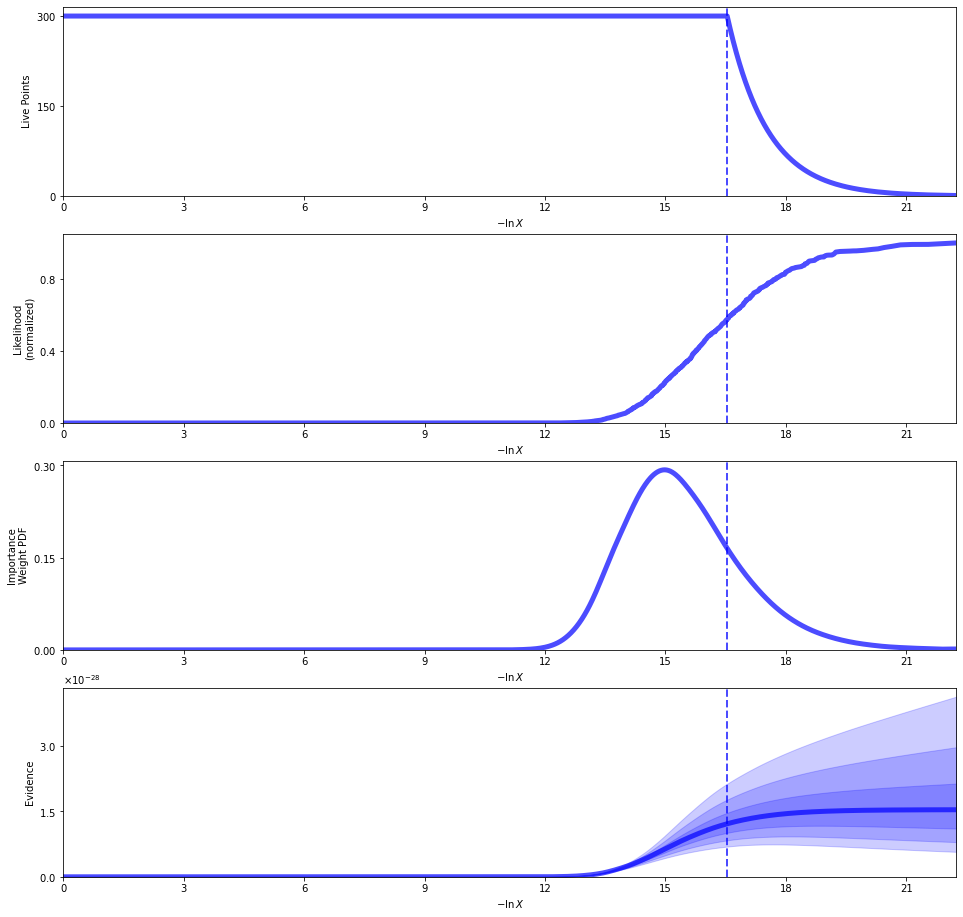

In [10]:
rfig, raxes = dyplot.runplot(sresults)

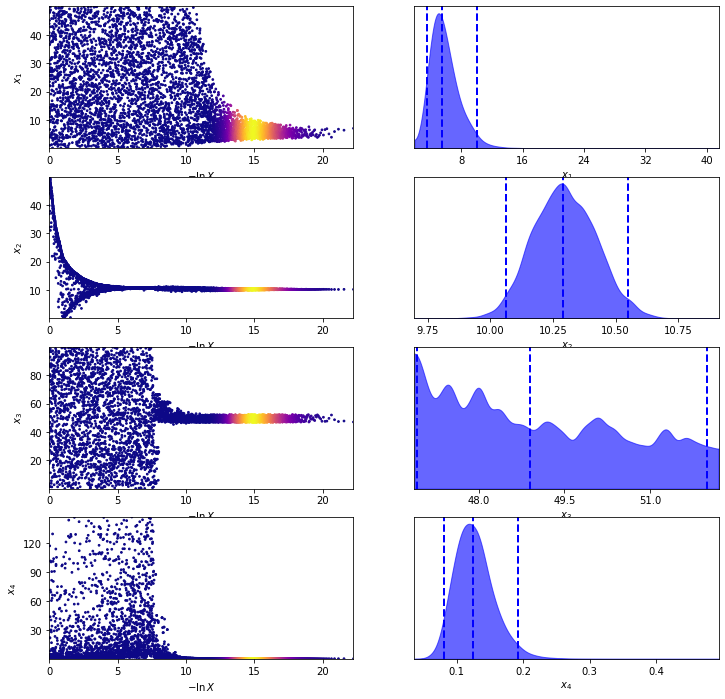

In [11]:
tfig, taxes = dyplot.traceplot(sresults)

In [12]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence_burst = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_burst))

# Compute 5%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.05, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 1.5384582857838235e-28
90% parameter credible regions are:
 [[3.627966166897282, 8.25824487470988], [10.099795718292203, 10.456937344949747], [47.000236981406324, 51.39570791489074], [0.08554062075424257, 0.16450329237197855]]

Mean and covariance of parameters are: [ 5.83279055 10.29583982 49.10642106  0.12637449]
[[ 3.29634660e+00  2.54969404e-02 -1.84250146e+00  3.27740070e-02]
 [ 2.54969404e-02  1.53341474e-02 -1.22468597e-02  1.41193874e-03]
 [-1.84250146e+00 -1.22468597e-02  2.39843583e+00 -2.84345444e-03]
 [ 3.27740070e-02  1.41193874e-03 -2.84345444e-03  8.35768700e-04]]


In [13]:
samples_equal = dyfunc.resample_equal(samples, weights)

In [14]:
quantile_value_25 = np.percentile(samples_equal, 25, axis=0)
quantile_value_50 = np.percentile(samples_equal, 50, axis=0)
quantile_value_75 = np.percentile(samples_equal, 75, axis=0)

# i use quantiles to compute the 68% and the 95% credible regions

# 68%
quantile_value_16 = np.percentile(samples_equal, 16, axis=0)
quantile_value_84 = np.percentile(samples_equal, 84, axis=0)

# 95%
quantile_value_2_5 = np.percentile(samples_equal, 2.5, axis=0)
quantile_value_97_5 = np.percentile(samples_equal, 97.5, axis=0)

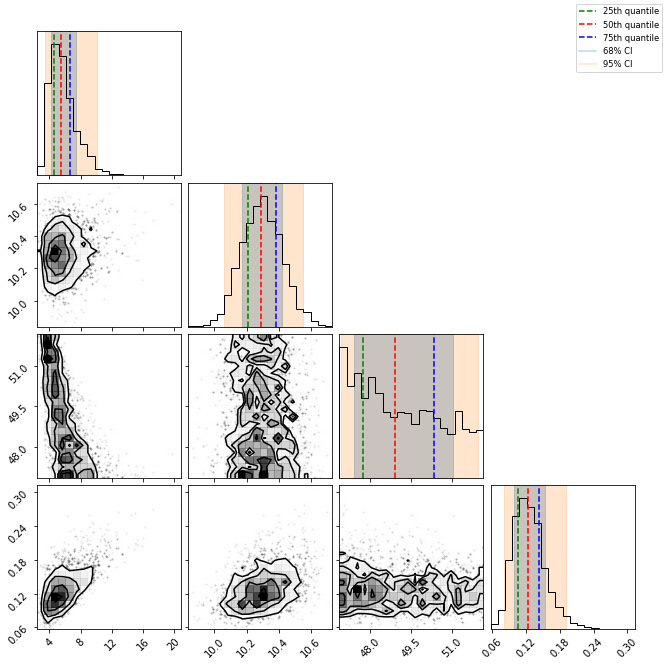

In [15]:
fig = corner.corner(samples_equal)

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(quantile_value_25[i], color="g", linestyle='dashed')
    ax.axvline(quantile_value_50[i], color="r", linestyle='dashed')
    ax.axvline(quantile_value_75[i], color="b", linestyle='dashed')
    
    ax.fill_betweenx(
        [0, ax.get_ylim()[1]],  
        quantile_value_16[i], quantile_value_84[i],
        color='C0', alpha=0.3)
    ax.fill_betweenx(
        [0, ax.get_ylim()[1]],  
        quantile_value_2_5[i], quantile_value_97_5[i],
        color='C1', alpha=0.2)

# labels
handles = [
    plt.Line2D([], [], color='g', linestyle='--'),
    plt.Line2D([], [], color='r', linestyle='--'),
    plt.Line2D([], [], color='b', linestyle='--'),
    plt.Line2D([], [], color='C0', alpha=0.3),
    plt.Line2D([], [], color='C1', alpha=0.2)
]

labels = ['25th quantile', '50th quantile', '75th quantile', '68% CI', '95% CI']

plt.figlegend(handles, labels, loc='upper right', fontsize='small');

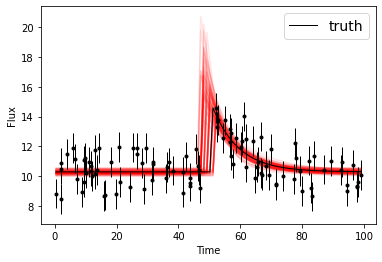

In [16]:
inds = np.random.randint(len(samples_equal), size=100)
for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_model, model_fit(x_model, sample[0], sample[1], sample[2], sample[3]), "r", alpha=0.1)
plt.errorbar(time, flux, yerr=flux_err, fmt=".k", lw=1)
plt.plot(x_model, model_fit(x_model, A, b, t_0, alpha), "k", lw=1, label="truth")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("Flux");

In [17]:
labels = ['A', 'b', 't_0', 'alpha']
for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Gaussian profile

In [18]:
def model_gauss(t, theta):
    
    A, b, t_0, sigma = theta
    return b + A*np.exp(-(time-t_0)**2 / (2*sigma**2))

def model_gauss_fit(time, A, b, t_0, sigma):
    
    return b + A*np.exp(-(time-t_0)**2 / (2*sigma**2))

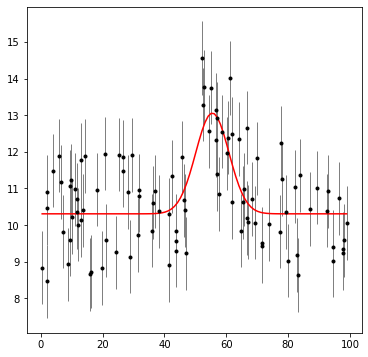

In [19]:
popt, pcov = curve_fit(model_gauss_fit, time, flux, p0=[3,10,55,5])
A_opt, b_opt, t0_opt, sigma_opt = popt
x_model = np.linspace(min(time), max(time), 100)
y_model = model_gauss_fit(x_model, A_opt, b_opt, t0_opt, sigma_opt) 

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, flux_err, 
            fmt='.k', lw=1, ecolor='gray');

plt.plot(x_model, y_model, color='r')
plt.show()

In [20]:
A_gauss = popt[0]
b_gauss = popt[1]
t_0_gauss = popt[2]
sigma_gauss = popt[3]
print(popt)

[ 2.75113442 10.30693377 55.47300903  5.36943502]


In [21]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

In [25]:
def loglike_gauss(theta):
    
    A, b, t_0, sigma = theta
    model_wgauss = model_gauss(time, theta)
    
    return -0.5 * np.sum(((flux - model_wgauss) / flux_err) ** 2)

def ptform_gauss(u):
    
    x = np.array(u)
    
    '''lower_bound = [0, 0, 0, 0]
    upper_bound = [50, 50, 100, 10]
    
    x = [lower_bound[i] + u[i] * (upper_bound[i] - lower_bound[i]) for i in range(len(u))]'''
    
    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
    
    return x

In [26]:
ndim = 4
sampler = dynesty.NestedSampler(loglike_gauss, ptform_gauss, ndim, nlive=300, sample='rwalk')
sampler.run_nested()
sresults = sampler.results

5180it [04:57, 17.44it/s, +300 | bound: 92 | nc: 1 | ncall: 109346 | eff(%):  5.025 | loglstar:   -inf < -52.425 <    inf | logz: -68.442 +/-  0.224 | dlogz:  0.001 >  0.309]


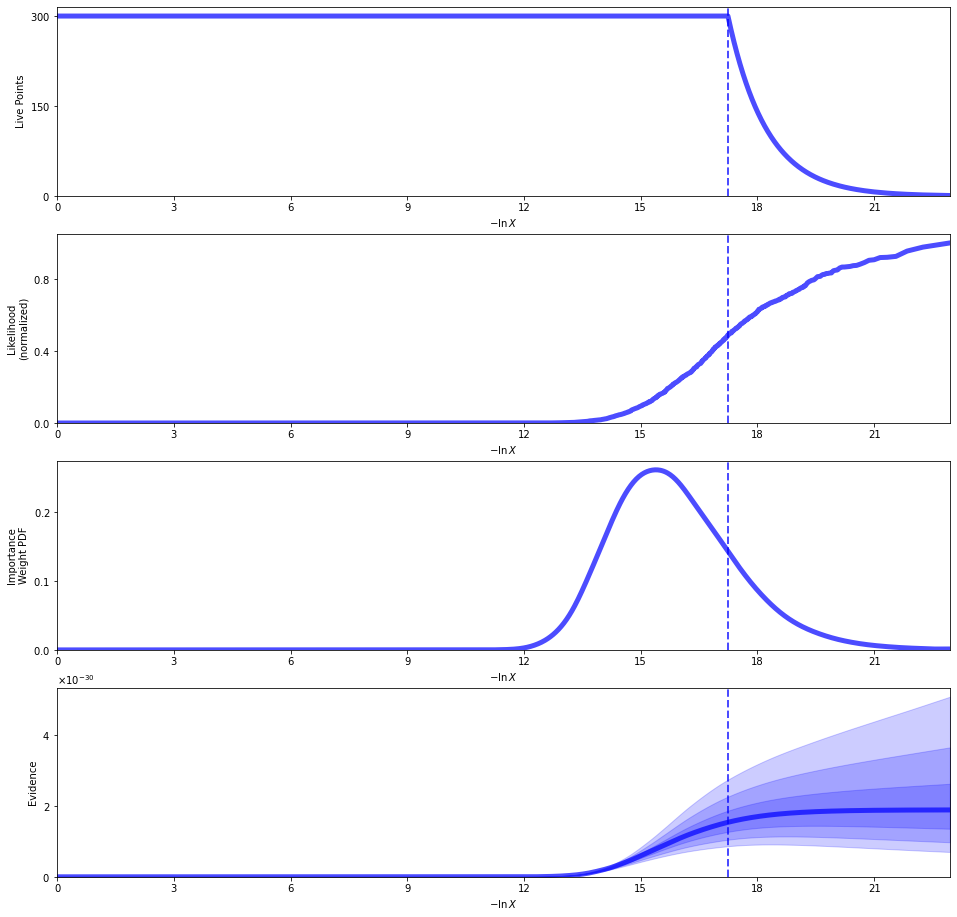

In [27]:
rfig, raxes = dyplot.runplot(sresults)

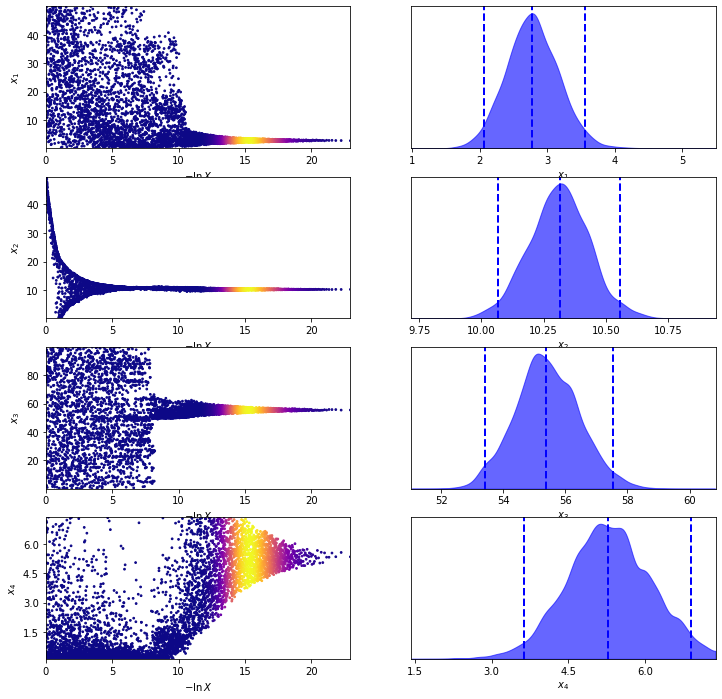

In [28]:
tfig, taxes = dyplot.traceplot(sresults)

In [29]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence_gauss = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_gauss))

# Compute 5%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.05, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 1.888326185472018e-30
90% parameter credible regions are:
 [[2.164689092152439, 3.2704020047969182], [10.113264623908128, 10.458958422525596], [53.73784970474846, 56.72642776556278], [3.941383542567203, 6.3616284796493145]]

Mean and covariance of parameters are: [ 2.78096679 10.31079856 55.40717587  5.28602464]
[[ 0.14735713 -0.009919   -0.1372846  -0.13209412]
 [-0.009919    0.01454835 -0.02176978 -0.03820701]
 [-0.1372846  -0.02176978  1.04345857  0.30034062]
 [-0.13209412 -0.03820701  0.30034062  0.67579185]]


In [30]:
quantile_value_25 = np.percentile(samples_equal, 25, axis=0)
quantile_value_50 = np.percentile(samples_equal, 50, axis=0)
quantile_value_75 = np.percentile(samples_equal, 75, axis=0)

# i use quantiles to compute the 68% and the 95% credible regions

# 68%
quantile_value_16 = np.percentile(samples_equal, 16, axis=0)
quantile_value_84 = np.percentile(samples_equal, 84, axis=0)

# 95%
quantile_value_2_5 = np.percentile(samples_equal, 2.5, axis=0)
quantile_value_97_5 = np.percentile(samples_equal, 97.5, axis=0)

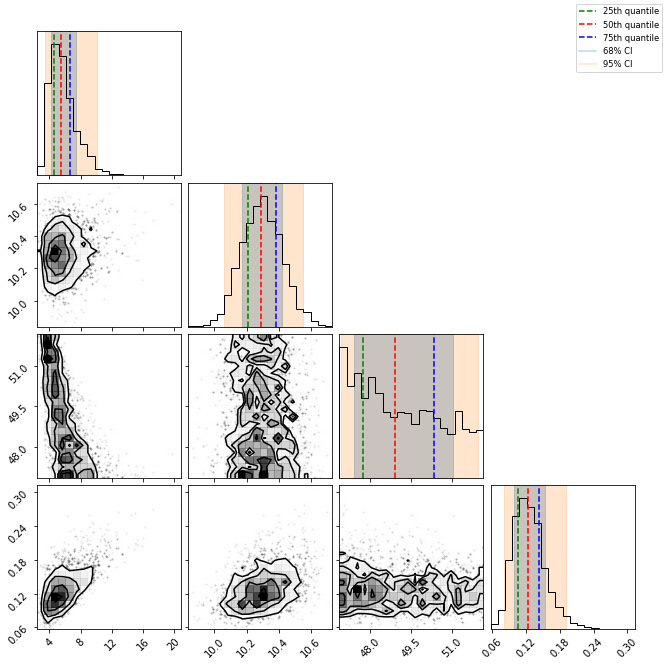

In [31]:
fig = corner.corner(samples_equal)

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(quantile_value_25[i], color="g", linestyle='dashed')
    ax.axvline(quantile_value_50[i], color="r", linestyle='dashed')
    ax.axvline(quantile_value_75[i], color="b", linestyle='dashed')
    
    ax.fill_betweenx(
        [0, ax.get_ylim()[1]],  
        quantile_value_16[i], quantile_value_84[i],
        color='C0', alpha=0.3)
    ax.fill_betweenx(
        [0, ax.get_ylim()[1]],  
        quantile_value_2_5[i], quantile_value_97_5[i],
        color='C1', alpha=0.2)

# labels
handles = [
    plt.Line2D([], [], color='g', linestyle='--'),
    plt.Line2D([], [], color='r', linestyle='--'),
    plt.Line2D([], [], color='b', linestyle='--'),
    plt.Line2D([], [], color='C0', alpha=0.3),
    plt.Line2D([], [], color='C1', alpha=0.2)
]

labels = ['25th quantile', '50th quantile', '75th quantile', '68% CI', '95% CI']

plt.figlegend(handles, labels, loc='upper right', fontsize='small');

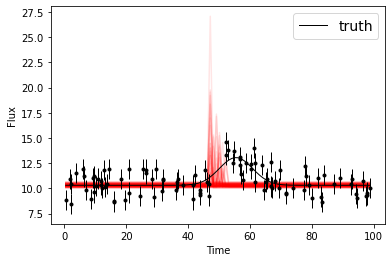

In [32]:
inds = np.random.randint(len(samples_equal), size=100)
for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_model, model_gauss_fit(x_model, sample[0], sample[1], sample[2], sample[3]), "r", alpha=0.1)
plt.errorbar(time, flux, yerr=flux_err, fmt=".k", lw=1)
plt.plot(x_model, model_gauss_fit(x_model, A_gauss, b_gauss, t_0_gauss, sigma_gauss), "k", lw=1, label="truth")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("Flux");

I can compute the Bayes factor as  
<center>$Bayes factor = \frac{Z_1}{Z_2}$,</center>  
where $Z_1$ and $Z_2$ are respectively the Bayesian evidence with the burst model and with the gaussian model.

In [34]:
bayes_factor = np.exp(evidence_burst) / np.exp(evidence_gauss)
print('The bayes factor results to be: ', "{:.10f}".format(bayes_factor))

The bayes factor results to be:  81.4720622750


The high Bayes factor indicates that the burst model is the favored one in respect to the gaussian one.